### Import Libraries

In [1]:
# ==============================
# 📦 Import Libraries
# ==============================
import os
import cv2
import shutil
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import keras_tuner as kt

# Set random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

### Load and Data Preprocessing 

In [3]:
def load_images(image_dir, mask_dir, image_size=(128, 128)):
    images, masks = [], []
    for filename in sorted(os.listdir(image_dir)):
        if not filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            continue
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)  # assumes same name pattern

        if not os.path.exists(mask_path):
            print(f"Mask missing for: {filename}")
            continue

        img = load_img(img_path, color_mode='grayscale', target_size=image_size)
        mask = load_img(mask_path, color_mode='grayscale', target_size=image_size)

        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)
    if masks.ndim == 3:
        masks = np.expand_dims(masks, axis=-1)
    return images, masks


base_path = "Train_Dataset_Generated"
image_dir = os.path.join(base_path, 'img')
mask_dir = os.path.join(base_path, 'mask')

images, masks = load_images(image_dir, mask_dir)
print(f"Loaded {len(images)} images and {len(masks)} masks.")

Loaded 160 images and 160 masks.


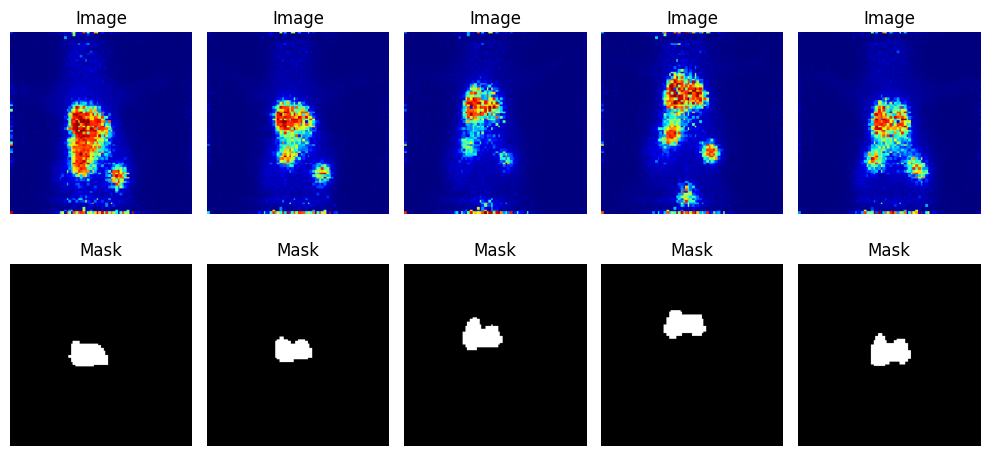

In [4]:
# Visualize some images and masks
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        if i >= len(images):
            break
        # Display image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[6*i].squeeze(), cmap='jet')
        plt.axis('off')
        plt.title("Image")
        
        # Display mask
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(masks[6*i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Mask")
    
    plt.tight_layout()
    plt.show()

visualize_samples(images, masks)

### Split Train/Test


In [5]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    images, masks, test_size=0.2, random_state=42
)
print("Training:", X_train.shape, "Testing:", X_test.shape)

Training: (128, 128, 128, 1) Testing: (32, 128, 128, 1)


### Define U-Net Builder for Tuning

In [6]:
def res_block(x, filters, dropout_rate):
    shortcut = x

    # First conv
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    # Second conv
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)

    # Residual connection
    shortcut = Conv2D(filters, (1, 1), activation='relu', padding='same')(shortcut)

    x = tf.keras.layers.Add()([shortcut, x])
    return x


def build_resunet_tuner(hp):
    inputs = Input((128, 128, 1))
    
    # Hyperparameters
    base_filters = hp.Choice('base_filters', values=[16, 32, 64])
    dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.1, 0.2, 0.3])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Encoder
    c1 = res_block(inputs, base_filters, dropout_rate)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = res_block(p1, base_filters * 2, dropout_rate)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = res_block(p2, base_filters * 4, dropout_rate)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = res_block(p3, base_filters * 8, dropout_rate)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = res_block(p4, base_filters * 16, dropout_rate)

    # Decoder
    u6 = Conv2DTranspose(base_filters * 8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = res_block(u6, base_filters * 8, dropout_rate)

    u7 = Conv2DTranspose(base_filters * 4, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = res_block(u7, base_filters * 4, dropout_rate)

    u8 = Conv2DTranspose(base_filters * 2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = res_block(u8, base_filters * 2, dropout_rate)

    u9 = Conv2DTranspose(base_filters, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = res_block(u9, base_filters, dropout_rate)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Compile
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


### Hyperparameter Tuning

In [9]:
tuner = kt.GridSearch(
    build_resunet_tuner,   # <-- use the ResUNet tuner builder
    objective="val_loss",
    max_trials=5,
    directory="resunet_tuner_dir",
    project_name="resunet_gridsearch",
)

tuner.search_space_summary()

tuner.search(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=3,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=3, 
        monitor='val_loss',
        restore_best_weights=True
    )]
)

tuner.results_summary()


Trial 5 Complete [00h 01m 23s]
val_loss: 0.02954053319990635

Best val_loss So Far: 0.018148567527532578
Total elapsed time: 00h 06m 08s
Results summary
Results in resunet_tuner_dir\resunet_gridsearch
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
base_filters: 16
dropout_rate: 0.0
learning_rate: 0.001
Score: 0.018148567527532578

Trial 2 summary
Hyperparameters:
base_filters: 16
dropout_rate: 0.0
learning_rate: 0.0001
Score: 0.02040911093354225

Trial 0 summary
Hyperparameters:
base_filters: 16
dropout_rate: 0.0
learning_rate: 0.01
Score: 0.023236406967043877

Trial 3 summary
Hyperparameters:
base_filters: 16
dropout_rate: 0.1
learning_rate: 0.01
Score: 0.02903878688812256

Trial 4 summary
Hyperparameters:
base_filters: 16
dropout_rate: 0.1
learning_rate: 0.001
Score: 0.02954053319990635


In [11]:
best_hps = tuner.get_best_hyperparameters(1)[0]

print(f"""
Best Hyperparameters:
base_filters = {best_hps.get('base_filters')}
dropout_rate = {best_hps.get('dropout_rate')}
learning_rate = {best_hps.get('learning_rate')}
""")



Best Hyperparameters:
base_filters = 16
dropout_rate = 0.0
learning_rate = 0.001



In [12]:
model = build_resunet_tuner(best_hps)
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=4,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.9146 - loss: 0.2584 - val_accuracy: 0.9732 - val_loss: 0.0639
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.9761 - loss: 0.0630 - val_accuracy: 0.9764 - val_loss: 0.0463
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9819 - loss: 0.0410 - val_accuracy: 0.9828 - val_loss: 0.0402
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.9851 - loss: 0.0364 - val_accuracy: 0.9842 - val_loss: 0.0393
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.9832 - loss: 0.0414 - val_accuracy: 0.9823 - val_loss: 0.0448
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.9855 - loss: 0.0358 - val_accuracy: 0.9855 - val_loss: 0.0361
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9846 - loss: 0.0358 - val_accuracy: 0.9834 - val_loss: 0.0520
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.9866 - loss: 0.0337 - val_accuracy: 0

In [13]:
model.save('model_3_Res_Unet.h5')

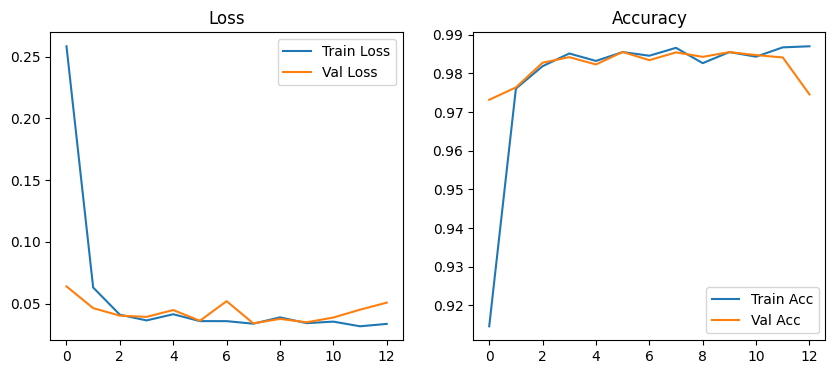

In [14]:
# -------------------------------
# Plot Training Curves
# -------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()


In [8]:
from tensorflow.keras.models import load_model

model = load_model('z_models/model_2_Res_Unet.h5', compile=False)


In [9]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

preds_test = model.predict(X_test)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

dice_scores = []
precisions = []
recalls = []
accuracies = []

TP_total = 0
TN_total = 0
FP_total = 0
FN_total = 0

for i in range(len(X_test)):
    y_true = y_test[i].squeeze()
    y_pred = preds_test_t[i].squeeze()
    
    # Flatten for sklearn metrics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    dice_scores.append(dice_coef(y_true, y_pred))
    precisions.append(precision_score(y_true_flat, y_pred_flat))
    recalls.append(recall_score(y_true_flat, y_pred_flat))
    accuracies.append(accuracy_score(y_true_flat, y_pred_flat))
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat, labels=[0,1]).ravel()
    TP_total += tp
    TN_total += tn
    FP_total += fp
    FN_total += fn

print(f"Average Dice Coefficient: {np.mean(dice_scores):.3f}")
print(f"Average Precision: {np.mean(precisions):.3f}")
print(f"Average Recall: {np.mean(recalls):.3f}")
print(f"Average Accuracy: {np.mean(accuracies):.3f}")

print("\nTotal Confusion Matrix:")
print(f"TP: {TP_total}, TN: {TN_total}, FP: {FP_total}, FN: {FN_total}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Average Dice Coefficient: 0.751
Average Precision: 0.716
Average Recall: 0.824
Average Accuracy: 0.985

Total Confusion Matrix:
TP: 11220, TN: 505463, FP: 5153, FN: 2452


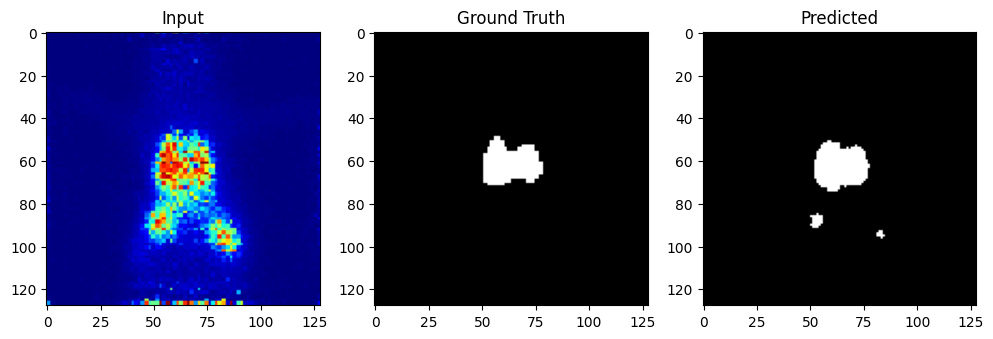

In [13]:
# -------------------------------
# Visualize a Random Prediction
# -------------------------------
import random
ix = random.randint(0, len(X_test) - 1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(X_test[ix].squeeze(), cmap='jet'); plt.title('Input')
plt.subplot(1,3,2); plt.imshow(y_test[ix].squeeze(), cmap='gray'); plt.title('Ground Truth')
plt.subplot(1,3,3); plt.imshow(preds_test_t[ix].squeeze(), cmap='gray'); plt.title('Predicted')
plt.show()